# Artificial Neural Networks and Deep Learning  

## Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [ ]:
# Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi

Sun Jul 27 19:28:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [ ]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()  # Apply the default theme
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

In [ ]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [ ]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

# where to save the model
model_save = './MNIST_CNN/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN'):
    os.mkdir('MNIST_CNN')

In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.324662 Batch 0/100 
Training Loss:0.831864 Batch 20/100 
Training Loss:0.446550 Batch 40/100 
Training Loss:0.175834 Batch 60/100 
Training Loss:0.222280 Batch 80/100 
Epoch 0, Test Accuracy 94.250 %
Training Loss:0.136606 Batch 0/100 
Training Loss:0.157504 Batch 20/100 
Training Loss:0.108435 Batch 40/100 
Training Loss:0.186818 Batch 60/100 
Training Loss:0.072828 Batch 80/100 
Epoch 1, Test Accuracy 95.950 %
Training Loss:0.069139 Batch 0/100 
Training Loss:0.080893 Batch 20/100 
Training Loss:0.079676 Batch 40/100 
Training Loss:0.085150 Batch 60/100 
Training Loss:0.043741 Batch 80/100 
Epoch 2, Test Accuracy 96.650 %
Training Loss:0.095724 Batch 0/100 
Training Loss:0.067623 Batch 20/100 
Training Loss:0.033836 Batch 40/100 
Training Loss:0.027102 Batch 60/100 
Training Loss:0.028757 Batch 80/100 
Epoch 3, Test Accuracy 96.450 %
Training Loss:0.107399 Batch 0/100 
Training Loss:0.016418 Batch 20/100 
Training Loss:0.083493 Batch 40/100 
Training Loss:0.054523 Bat

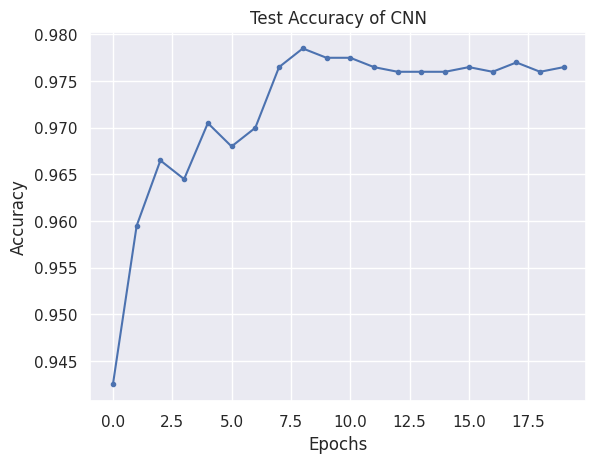

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

## Trying Different Architectures

In [ ]:
import torch
import torch.nn as nn

class ConfigurableCNN(nn.Module):
    def __init__(self,
                 in_channels=1,
                 num_conv_layers=4,
                 num_filters=[16, 32, 32, 64],
                 kernel_size=3,
                 stride=2,
                 padding=1,
                 num_fc_layers=2,
                 fc_dims=[100, 10],
                 input_shape=(1, 28, 28)):  # e.g., MNIST images

        super(ConfigurableCNN, self).__init__()

        assert num_conv_layers == len(num_filters), "num_conv_layers must match length of num_filters"
        assert num_fc_layers == len(fc_dims), "num_fc_layers must match length of fc_dims"

        self.convs = nn.Sequential()
        current_channels = in_channels
        current_shape = input_shape

        for i in range(num_conv_layers):
            conv = nn.Conv2d(current_channels, num_filters[i], kernel_size, stride, padding)
            bn = nn.BatchNorm2d(num_filters[i])
            relu = nn.ReLU()
            self.convs.add_module(f'conv{i+1}', conv)
            self.convs.add_module(f'bn{i+1}', bn)
            self.convs.add_module(f'relu{i+1}', relu)

            # Estimate output size after this conv layer
            h, w = current_shape[1], current_shape[2]
            h = (h + 2 * padding - kernel_size) // stride + 1
            w = (w + 2 * padding - kernel_size) // stride + 1
            current_shape = (num_filters[i], h, w)
            current_channels = num_filters[i]

        self.flatten_dim = current_shape[0] * current_shape[1] * current_shape[2]

        # Build MLP layers
        fc_layers = []
        in_dim = self.flatten_dim
        for i in range(num_fc_layers):
            out_dim = fc_dims[i]
            fc_layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:
                fc_layers.append(nn.ReLU())
            in_dim = out_dim
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
train_epoch = 20
batch_size = 100
shuffle = True

train_loader, test_loader = get_mnist_loader(batch_size=batch_size)


Training model with 2 conv layers and filters [16, 32]
Training Loss:2.307900 Batch 0/100 
Training Loss:0.594512 Batch 20/100 
Training Loss:0.394742 Batch 40/100 
Training Loss:0.280754 Batch 60/100 
Training Loss:0.288851 Batch 80/100 
Epoch 0, Test Accuracy 94.100 %
Training Loss:0.243708 Batch 0/100 
Training Loss:0.240306 Batch 20/100 
Training Loss:0.223458 Batch 40/100 
Training Loss:0.181602 Batch 60/100 
Training Loss:0.127947 Batch 80/100 
Epoch 1, Test Accuracy 96.600 %
Training Loss:0.155525 Batch 0/100 
Training Loss:0.064446 Batch 20/100 
Training Loss:0.095746 Batch 40/100 
Training Loss:0.058243 Batch 60/100 
Training Loss:0.128444 Batch 80/100 
Epoch 2, Test Accuracy 96.850 %
Training Loss:0.068746 Batch 0/100 
Training Loss:0.033322 Batch 20/100 
Training Loss:0.017661 Batch 40/100 
Training Loss:0.031725 Batch 60/100 
Training Loss:0.041147 Batch 80/100 
Epoch 3, Test Accuracy 97.450 %
Training Loss:0.043090 Batch 0/100 
Training Loss:0.027885 Batch 20/100 
Trainin

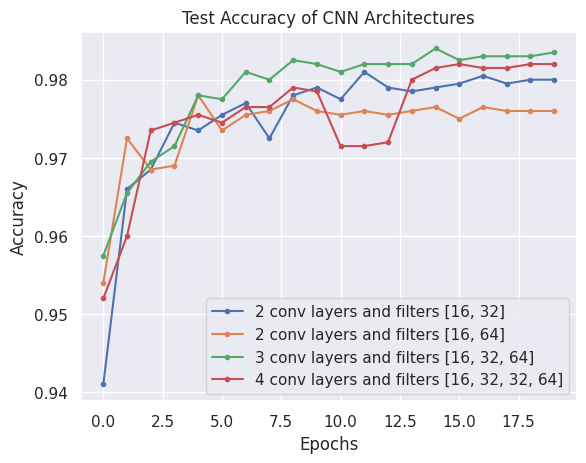

In [ ]:
conv_filter_search_grid = {
    "num_conv_layers": [2, 2, 3, 4],
    "num_filters": [[16, 32], [16, 64], [16, 32, 64], [16, 32, 32, 64]]
}

for num_conv_layers, num_filters in zip(conv_filter_search_grid["num_conv_layers"], conv_filter_search_grid["num_filters"]):
    print(f"\nTraining model with {num_conv_layers} conv layers and filters {num_filters}")

    model = ConfigurableCNN(
        num_conv_layers=num_conv_layers,
        num_filters=num_filters,
        kernel_size=3,
        stride=2,
        padding=1,
        num_fc_layers=2,
        fc_dims=[100, 10]
    )

    acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

    plt.plot(acc_count, marker='.', label=f'{num_conv_layers} conv layers and filters {num_filters}')


plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN Architectures')
plt.legend()
plt.show()


Training model with kernel_size=3, stride=2, padding=1
Training Loss:2.310029 Batch 0/100 
Training Loss:1.172639 Batch 20/100 
Training Loss:0.518003 Batch 40/100 
Training Loss:0.316172 Batch 60/100 
Training Loss:0.306720 Batch 80/100 
Epoch 0, Test Accuracy 95.450 %
Training Loss:0.102827 Batch 0/100 
Training Loss:0.177229 Batch 20/100 
Training Loss:0.105764 Batch 40/100 
Training Loss:0.059880 Batch 60/100 
Training Loss:0.210769 Batch 80/100 
Epoch 1, Test Accuracy 96.400 %
Training Loss:0.071944 Batch 0/100 
Training Loss:0.077789 Batch 20/100 
Training Loss:0.020387 Batch 40/100 
Training Loss:0.149251 Batch 60/100 
Training Loss:0.017179 Batch 80/100 
Epoch 2, Test Accuracy 97.300 %
Training Loss:0.044852 Batch 0/100 
Training Loss:0.071529 Batch 20/100 
Training Loss:0.090551 Batch 40/100 
Training Loss:0.048873 Batch 60/100 
Training Loss:0.039726 Batch 80/100 
Epoch 3, Test Accuracy 97.300 %
Training Loss:0.010935 Batch 0/100 
Training Loss:0.022743 Batch 20/100 
Trainin

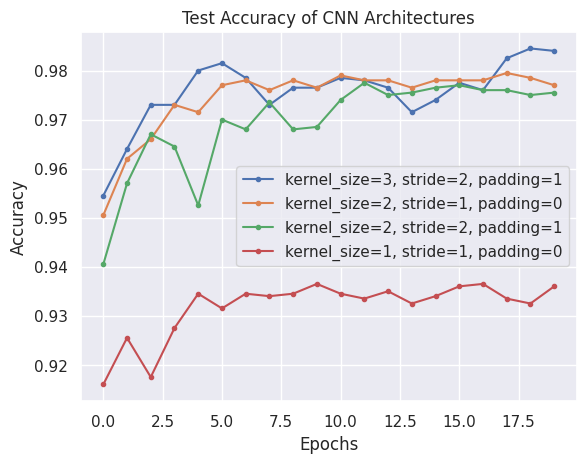

In [ ]:
num_layers, filters = 3, [16, 32, 64]  # Update based on previous step

conv_search_grid = {
    "kernel_size": [3, 2, 2, 1],
    "stride":      [2, 1, 2, 1],
    "padding":     [1, 0, 1, 0]
}

for kernel_size, stride, padding in zip(conv_search_grid["kernel_size"], conv_search_grid["stride"], conv_search_grid["padding"]):
    print(f"\nTraining model with kernel_size={kernel_size}, stride={stride}, padding={padding}")

    model = ConfigurableCNN(
        num_conv_layers=num_conv_layers,
        num_filters=num_filters,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        num_fc_layers=2,
        fc_dims=[100, 10]
    )

    acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

    plt.plot(acc_count, marker='.', label=f'kernel_size={kernel_size}, stride={stride}, padding={padding}')


plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN Architectures')
plt.legend()
plt.show()


Training model with 1 FC layers and dims=[10]
Training Loss:2.428307 Batch 0/100 
Training Loss:0.992601 Batch 20/100 
Training Loss:0.576001 Batch 40/100 
Training Loss:0.495462 Batch 60/100 
Training Loss:0.376120 Batch 80/100 
Epoch 0, Test Accuracy 95.250 %
Training Loss:0.246439 Batch 0/100 
Training Loss:0.156356 Batch 20/100 
Training Loss:0.123179 Batch 40/100 
Training Loss:0.105843 Batch 60/100 
Training Loss:0.120002 Batch 80/100 
Epoch 1, Test Accuracy 97.350 %
Training Loss:0.056170 Batch 0/100 
Training Loss:0.060367 Batch 20/100 
Training Loss:0.100325 Batch 40/100 
Training Loss:0.038085 Batch 60/100 
Training Loss:0.138893 Batch 80/100 
Epoch 2, Test Accuracy 97.100 %
Training Loss:0.054130 Batch 0/100 
Training Loss:0.045105 Batch 20/100 
Training Loss:0.037713 Batch 40/100 
Training Loss:0.073069 Batch 60/100 
Training Loss:0.093365 Batch 80/100 
Epoch 3, Test Accuracy 97.550 %
Training Loss:0.032334 Batch 0/100 
Training Loss:0.026477 Batch 20/100 
Training Loss:0.

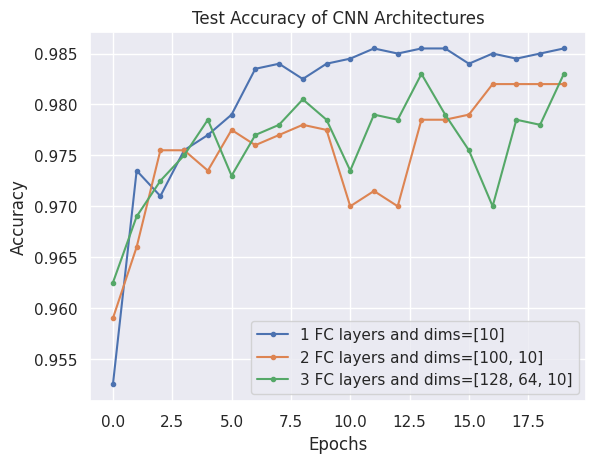

In [ ]:
num_layers, filters = 3, [16, 32, 64]  # Update based on previous step
kernel_size, stride, padding = 3, 2, 1  # Update based on previous step

fc_search_grid = {
    "num_fc_layers": [1, 2, 3],
    "fc_dims": [
        [10],
        [100, 10],
        [128, 64, 10]
    ]
}

for num_fc_layers, fc_dims in zip(fc_search_grid["num_fc_layers"], fc_search_grid["fc_dims"]):
    print(f"\nTraining model with {num_fc_layers} FC layers and dims={fc_dims}")

    model = ConfigurableCNN(
        num_conv_layers=num_conv_layers,
        num_filters=num_filters,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        num_fc_layers=num_fc_layers,
        fc_dims=fc_dims
    )

    acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

    plt.plot(acc_count, marker='.', label=f'{num_fc_layers} FC layers and dims={fc_dims}')


plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN Architectures')
plt.legend()
plt.show()